# Symbolic Image Filtering

In [1]:
import pymbolic.primitives as p

u_var = p.Variable("u")

Want to define an image filter.

----

To that end, define a new formula 'thing': A neighbor-average.

In [2]:
class NeighborAverage(p.Expression):
    def __init__(self, child):
        self.child = child
        
    def __getinitargs__(self):
        return (self.child,)
    
    mapper_method = "map_neighbor_average"
        
img_filter = NeighborAverage(u_var)
#img_filter = u_var + u_var - NeighborAverage(u_var)

img_filter

NeighborAverage(Variable('u'))

Let's define some indexing variables:

In [3]:
from pymbolic.mapper import IdentityMapper

i = p.Variable("i")
j = p.Variable("j")

ii = i+1
jj = j+1

In [4]:
class IndexMapper(IdentityMapper):
    def map_variable(self, expr):
        return expr[ii, jj]
    
    def map_neighbor_average(self, expr):
        var = expr.child
        return (2*var[ii,jj] + var[ii+1,jj] + var[ii-1,jj]
                + var[ii,jj+1] + var[ii,jj-1])/6

Now apply this to our filter:

In [5]:
idx_mapper = IndexMapper()
print(idx_mapper(img_filter))

(2*u[i + 1, j + 1] + u[i + 1 + 1, j + 1] + u[i + 1 + -1, j + 1] + u[i + 1, j + 1 + 1] + u[i + 1, j + 1 + -1]) / 6


----

Now let's generate some code for this, using `loopy`:

In [6]:
import loopy as lp
result_var = p.Variable("result")

Observe the two parts of the `loopy` kernel description:

* Polyhedral loop domain
* Instructions `[lp.ExpressionInstruction()]`

In [23]:
#clear
knl = lp.make_kernel(
    "{[i,j]: 0<=i,j<n}",
    [lp.ExpressionInstruction(result_var[ii,jj], idx_mapper(img_filter))],
    [lp.GlobalArg("result", shape="n+2, n+2"), ...]
    )

Kernels can always be inspected--simply use `print`:

In [24]:
print(knl)

---------------------------------------------------------------------------
KERNEL: loopy_kernel
---------------------------------------------------------------------------
ARGUMENTS:
n: ValueArg, type: <runtime>
result: GlobalArg, type: <runtime>, shape: (n + 2, n + 2), dim_tags: (N1:stride:n + 2, N0:stride:1)
u: GlobalArg, type: <runtime>, shape: (2 + n, 2 + n), dim_tags: (N1:stride:2 + n, N0:stride:1)
---------------------------------------------------------------------------
DOMAINS:
[n] -> { [i, j] : i >= 0 and j >= 0 and i <= -1 + n and j <= -1 + n }
---------------------------------------------------------------------------
INAME IMPLEMENTATION TAGS:
i: None
j: None
---------------------------------------------------------------------------
INSTRUCTIONS:
[i,j]                                result[i + 1, j + 1] <- (2*u[i + 1, j + 1] + u[i + 1 + 1, j + 1] + u[i + 1 + -1, j + 1] + u[i + 1, j + 1 + 1] + u[i + 1, j + 1 + -1]) / 6   # insn
--------------------------------------------

----

Let's move towards running this code. To do so, we need `pyopencl`:

In [25]:
import numpy as np
import pyopencl as cl
import pyopencl.array
import pyopencl.clrandom

ctx = cl.create_some_context()
queue = cl.CommandQueue(ctx)

And some data to work with:

In [26]:
n = 200

import scipy.misc
u = scipy.misc.imread("cat.jpeg").astype(np.float32).sum(axis=2)/(3*256)
u = cl.array.to_device(queue, u)

/usr/lib/python3/dist-packages/PIL/Image.py:665: ResourceWarning: unclosed file <_io.BufferedReader name='cat.jpeg'>
  self.load()


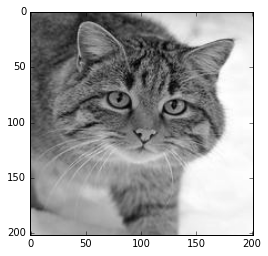

In [27]:
import matplotlib.pyplot as pt
pt.imshow(u.get(), cmap="gray")

Now run the code, and tell loopy to print what it generates:

In [31]:
knl = lp.set_options(knl, write_cl=True)

result = cl.array.zeros_like(u)
_ = knl(queue, u=u, result=result, n=n)
u = result

#define lid(N) ((int) get_local_id(N))
#define gid(N) ((int) get_group_id(N))

__kernel void __attribute__ ((reqd_work_group_size(1, 1, 1))) loopy_kernel(__global float *restrict result, int const n, __global float const *restrict u)
{

  for (int j = 0; j <= -1 + n; ++j)
    for (int i = 0; i <= -1 + n; ++i)
      result[(n + 2) * (i + 1) + j + 1] = (2.0f * u[(2 + n) * (i + 1) + j + 1] + u[(2 + n) * (i + 1 + 1) + j + 1] + u[(2 + n) * (i + 1 + -1) + j + 1] + u[(2 + n) * (i + 1) + j + 1 + 1] + u[(2 + n) * (i + 1) + j + 1 + -1]) / 6.0f;
}


/home/andreas/src/loopy/loopy/compiled.py:841: LoopyWarning: kernel scheduling was ambiguous--more than one schedule found, ignoring
  kernel = get_one_scheduled_kernel(kernel)


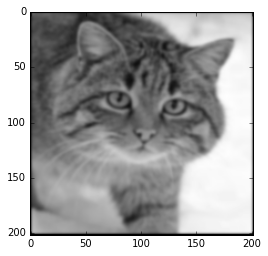

In [32]:
pt.imshow(u.get(), cmap="gray", vmin=0, vmax=1)

That's obviously not very parallel. Introduce parallelism:

In [33]:
tknl = knl
tknl = lp.tag_inames(tknl, {"i": "g.0", "j": "g.1"})
evt, (result,) = tknl(queue, u=u)

#define lid(N) ((int) get_local_id(N))
#define gid(N) ((int) get_group_id(N))

__kernel void __attribute__ ((reqd_work_group_size(1, 1, 1))) loopy_kernel(__global float *restrict result, int const n, __global float const *restrict u)
{

  result[(n + 2) * (gid(0) + 1) + gid(1) + 1] = (2.0f * u[(2 + n) * (gid(0) + 1) + gid(1) + 1] + u[(2 + n) * (gid(0) + 1 + 1) + gid(1) + 1] + u[(2 + n) * (gid(0) + 1 + -1) + gid(1) + 1] + u[(2 + n) * (gid(0) + 1) + gid(1) + 1 + 1] + u[(2 + n) * (gid(0) + 1) + gid(1) + 1 + -1]) / 6.0f;
}


/home/andreas/src/loopy/loopy/diagnostic.py:60: LoopyAdvisory: No device parameter was passed to the PyOpenCLTarget. Perhaps you want to pass a device to benefit from additional checking. (add 'no_device_in_pre_codegen_checks' to silenced_warnings kernel argument to disable)
  warn(text, type)


But OpenCL/CUDA require blocking to be efficient!

In [34]:
sknl = knl
sknl = lp.split_iname(sknl,
        "i", 16, outer_tag="g.1", inner_tag="l.1")
sknl = lp.split_iname(sknl,
        "j", 16, outer_tag="g.0", inner_tag="l.0")
evt, (result,) = sknl(queue, u=u)

#define lid(N) ((int) get_local_id(N))
#define gid(N) ((int) get_group_id(N))

__kernel void __attribute__ ((reqd_work_group_size(16, 16, 1))) loopy_kernel(__global float *restrict result, int const n, __global float const *restrict u)
{

  if (
      -1 + -16 * gid(0) + -1 * lid(0) + n >= 0
      && -1 + -16 * gid(1) + -1 * lid(1) + n >= 0
    )
    result[(n + 2) * (1 + lid(1) + gid(1) * 16) + 1 + lid(0) + gid(0) * 16] = (2.0f * u[(2 + n) * (1 + lid(1) + gid(1) * 16) + 1 + lid(0) + gid(0) * 16] + u[(2 + n) * (1 + 1 + lid(1) + gid(1) * 16) + 1 + lid(0) + gid(0) * 16] + u[(2 + n) * (1 + -1 + lid(1) + gid(1) * 16) + 1 + lid(0) + gid(0) * 16] + u[(2 + n) * (1 + lid(1) + gid(1) * 16) + 1 + 1 + lid(0) + gid(0) * 16] + u[(2 + n) * (1 + lid(1) + gid(1) * 16) + 1 + -1 + lid(0) + gid(0) * 16]) / 6.0f;
}


/home/andreas/src/loopy/loopy/diagnostic.py:60: LoopyAdvisory: No device parameter was passed to the PyOpenCLTarget. Perhaps you want to pass a device to benefit from additional checking. (add 'no_device_in_pre_codegen_checks' to silenced_warnings kernel argument to disable)
  warn(text, type)


How about some data reuse?

In [ ]:
sknl = knl
sknl = lp.split_iname(sknl,
        "i", 16, outer_tag="g.1", inner_tag="l.1")
sknl = lp.split_iname(sknl,
        "j", 16, outer_tag="g.0", inner_tag="l.0")
sknl = lp.add_prefetch(sknl, "u",
    ["i_inner", "j_inner"],
    fetch_bounding_box=True)
evt, (result,) = sknl(queue, u=u, n=n)